## Import Modules

In [1]:
#EDA notebook
#Feature selection notebook
#Modeling Testing Notebook
#Final Modeling Notebook

In [135]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from scipy import stats
from scipy.stats import norm

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

## Read in CSV Files

In [3]:
train = pd.read_csv('./data/train.csv')
train.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500


# Clean Train Data

## Remove Spaces in Column Titles

In [4]:
train.columns = train.columns.str.replace(' ', '')

## Drop Columns [Id, PID, SalePrice]

In [5]:
train.drop(['Id', 'PID'], axis=1, inplace=True)

## Change Type for Columns

**Convert 'MSSubclass' and 'Yr Sold' to Categorical**

In [6]:
train['MSSubClass'] = train['MSSubClass'].astype(object)
train['YrSold'] = train['YrSold'].astype(object)

## Null Values

In [166]:
train.isnull().sum()[train.isnull().sum() > 0].sort_values(ascending=False)

Series([], dtype: int64)

**Categorical Columns**

I replaced all of the Null values in the categorical columns with the string 'None.'

In [8]:
categorical_null_cols = ['MiscFeature', 'Alley', 'Fence',
 'FireplaceQu','GarageQual', 'GarageCond',
 'GarageFinish','GarageType', 'BsmtExposure',
 'BsmtFinType2', 'BsmtCond', 'BsmtQual',
 'BsmtFinType1', 'MasVnrType']

In [9]:
for col in train.columns:
    if col in categorical_null_cols:
        train[col].fillna(value = 'None', inplace=True)

**Numeric Columns **

In the numeric columns with discrete values I replaced the Null values with 0.  In the numeric columns with contonuous values I replaced the Null values with the median value from the respective column.

In [10]:
numeric_null_cols = ['BsmtHalfBath',
 'BsmtFullBath','GarageCars']

In [11]:
numeric_median_cols = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
           'BsmtUnfSF', 'GarageArea', 'TotalBsmtSF']

In [12]:
for col in train.columns:
    if col in numeric_null_cols:
        train[col].fillna(value = 0, inplace=True)

In [13]:
for col in train.columns:
    if col in numeric_median_cols:
        train[col].fillna(value = train[col].median(), inplace=True)

1564 of non null GarageYrBlt values match YearBuilt, whilst it is not over 90% of the values, we can assume that for the vast majority of the cases, YearBuilt will be an accurate value to fill these missing values with.

In [14]:
counter = 0
for x in train[train['GarageYrBlt'].notnull()][['GarageYrBlt','YearBuilt']].values:
    if x[0] == x[1]:
        counter += 1
print(counter)

1564


In [15]:
train.loc[train['GarageYrBlt'].isnull(), 'GarageYrBlt'] = train[train['GarageYrBlt'].isnull()]['YearBuilt']

## Feature Engineering

**Removing Highly Correlated Columns (Multicollinearity)**

Add column that indicates whether or not house has been remodeled.

In [16]:
train.loc[train['YearBuilt'] != train['YearRemod/Add'], 'Remodeled'] = 'Remodeled'

In [17]:
train.loc[train['YearBuilt'] == train['YearRemod/Add'], 'Remodeled'] = 'Not Remodeled'

Remove columns that are redundant.  

In [18]:
columns_to_remove = []

columns_to_remove.append('GarageCars')
columns_to_remove.append('GarageYrBlt')

columns_to_remove.append('BsmtFinSF1')
columns_to_remove.append('BsmtFinSF2')
columns_to_remove.append('BsmtUnfSF')

columns_to_remove.append('1stFlrSF')
columns_to_remove.append('2ndFlrSF')
columns_to_remove.append('LowQualFinSF')



train.drop(columns_to_remove, axis=1, inplace=True)

In [19]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2051 entries, 0 to 2050
Data columns (total 72 columns):
MSSubClass       2051 non-null object
MSZoning         2051 non-null object
LotFrontage      2051 non-null float64
LotArea          2051 non-null int64
Street           2051 non-null object
Alley            2051 non-null object
LotShape         2051 non-null object
LandContour      2051 non-null object
Utilities        2051 non-null object
LotConfig        2051 non-null object
LandSlope        2051 non-null object
Neighborhood     2051 non-null object
Condition1       2051 non-null object
Condition2       2051 non-null object
BldgType         2051 non-null object
HouseStyle       2051 non-null object
OverallQual      2051 non-null int64
OverallCond      2051 non-null int64
YearBuilt        2051 non-null int64
YearRemod/Add    2051 non-null int64
RoofStyle        2051 non-null object
RoofMatl         2051 non-null object
Exterior1st      2051 non-null object
Exterior2nd      2051 n

In [20]:
train['HouseStyle'].value_counts()

1Story    1059
2Story     598
1.5Fin     218
SLvl        94
SFoyer      50
2.5Unf      14
1.5Unf      12
2.5Fin       6
Name: HouseStyle, dtype: int64

## House Style and Mean Price

In [21]:
train[train['HouseStyle'] == '2Story']['SalePrice'].mean()

206408.96321070235

In [22]:
train[train['HouseStyle'] == '1.5Fin']['SalePrice'].mean()

136480.09174311926

In [23]:
train[train['HouseStyle'] == '1Story']['SalePrice'].mean()

179809.19452313503

## Heatmap for Numeric Columns

In [24]:
numeric_columns = train[train.select_dtypes(exclude = object).columns]
len(list(numeric_columns)), type(numeric_columns)

(27, pandas.core.frame.DataFrame)

In [25]:
corr = numeric_columns.corr()

In [26]:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

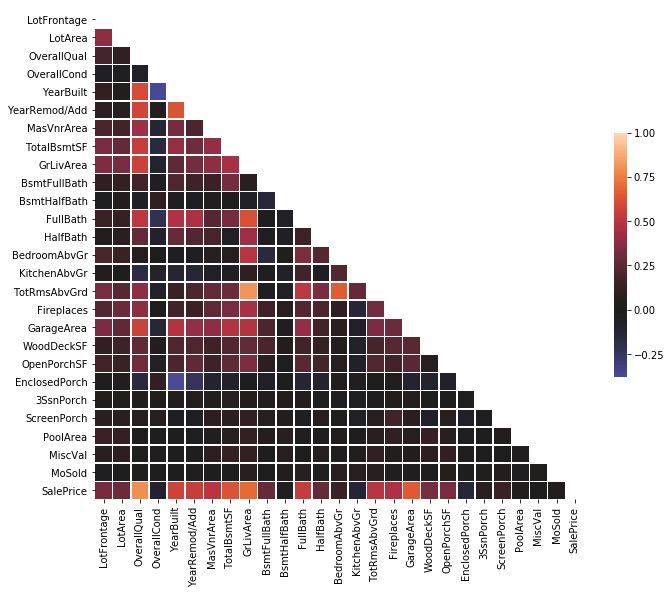

In [27]:
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Correlation Matrix for Numeric Columns

In [28]:
c = train.corr().abs().unstack().sort_values(ascending=False)
c[(c >= 0.5) | (c <= -0.5)]

SalePrice      SalePrice        1.000000
HalfBath       HalfBath         1.000000
PoolArea       PoolArea         1.000000
ScreenPorch    ScreenPorch      1.000000
3SsnPorch      3SsnPorch        1.000000
EnclosedPorch  EnclosedPorch    1.000000
OpenPorchSF    OpenPorchSF      1.000000
WoodDeckSF     WoodDeckSF       1.000000
GarageArea     GarageArea       1.000000
Fireplaces     Fireplaces       1.000000
TotRmsAbvGrd   TotRmsAbvGrd     1.000000
KitchenAbvGr   KitchenAbvGr     1.000000
FullBath       FullBath         1.000000
MoSold         MoSold           1.000000
BsmtHalfBath   BsmtHalfBath     1.000000
BsmtFullBath   BsmtFullBath     1.000000
GrLivArea      GrLivArea        1.000000
TotalBsmtSF    TotalBsmtSF      1.000000
MasVnrArea     MasVnrArea       1.000000
YearRemod/Add  YearRemod/Add    1.000000
YearBuilt      YearBuilt        1.000000
OverallCond    OverallCond      1.000000
OverallQual    OverallQual      1.000000
LotArea        LotArea          1.000000
MiscVal        M

In [29]:
train_corr = train.corr().sort_values('SalePrice', ascending=False)

In [30]:
def highlight(val):
    return 'background-color: yellow' if val > 0.5 else 'black'

In [31]:
train_corr.style.applymap(highlight)

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemod/Add,MasVnrArea,TotalBsmtSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,SalePrice
SalePrice,0.325129,0.296566,0.800207,-0.0970189,0.571849,0.55037,0.503579,0.628754,0.697038,0.283332,-0.0452903,0.537969,0.283001,0.137067,-0.125444,0.504014,0.471093,0.650241,0.32649,0.333476,-0.135656,0.0487319,0.134581,0.0231063,-0.00737476,0.0327354,1
OverallQual,0.182361,0.105824,1,-0.0827704,0.602964,0.584654,0.430041,0.548548,0.566701,0.175896,-0.047006,0.51508,0.274859,0.0533727,-0.170964,0.382025,0.38892,0.563719,0.257081,0.308855,-0.154554,0.0319377,0.0487522,0.00655824,0.0220987,0.0192424,0.800207
GrLivArea,0.349084,0.327427,0.566701,-0.109804,0.258838,0.322407,0.383875,0.453555,1,0.0643233,-0.0545227,0.617323,0.429707,0.507579,0.0970274,0.813333,0.458701,0.490907,0.270239,0.345008,-0.00777677,0.0245043,0.101926,0.113034,0.113673,0.0496443,0.697038
GarageArea,0.337745,0.263292,0.563719,-0.137906,0.486844,0.398961,0.380396,0.488738,0.490907,0.204621,-0.0249564,0.398214,0.177403,0.0699419,-0.0685383,0.341133,0.291581,1,0.245499,0.247181,-0.112033,0.0439162,0.0710614,0.0458746,0.0336395,0.00994371,0.650241
TotalBsmtSF,0.332511,0.277191,0.548548,-0.158666,0.410238,0.308457,0.403551,1,0.453555,0.321827,0.00570317,0.325582,-0.0550452,0.0491685,-0.0499877,0.293499,0.333093,0.488738,0.224679,0.257243,-0.0880252,0.06029,0.0760784,0.061507,0.125606,0.00396996,0.628754
YearBuilt,0.103534,0.0360023,0.602964,-0.370988,1,0.629116,0.32078,0.410238,0.258838,0.21559,-0.0312993,0.480169,0.283207,-0.042149,-0.127162,0.137783,0.168848,0.486844,0.216339,0.207798,-0.380082,0.0161044,-0.0378656,0.00372829,0.000625828,-0.00708309,0.571849
YearRemod/Add,0.0799094,0.0507713,0.584654,0.0426145,0.629116,1,0.204234,0.308457,0.322407,0.153771,-0.0377634,0.471555,0.224106,-0.0197479,-0.135926,0.202397,0.138858,0.398961,0.216271,0.264476,-0.237523,0.0404163,-0.0412107,-0.0223821,-0.00170428,0.011568,0.55037
FullBath,0.138012,0.125601,0.51508,-0.219189,0.480169,0.471555,0.232474,0.325582,0.617323,-0.0113804,-0.0601713,1,0.153656,0.344123,0.165939,0.51963,0.218833,0.398214,0.175502,0.244452,-0.125383,0.0278699,-0.0142957,0.0104583,0.00329273,0.0493902,0.537969
TotRmsAbvGrd,0.331864,0.238724,0.382025,-0.0935761,0.137783,0.202397,0.271657,0.293499,0.813333,-0.0399857,-0.0542624,0.51963,0.339638,0.655439,0.276663,1,0.311765,0.341133,0.182835,0.226346,0.00552058,-0.00810113,0.0463288,0.0724998,0.100175,0.0541542,0.504014
MasVnrArea,0.197858,0.16752,0.430041,-0.131908,0.32078,0.204234,1,0.403551,0.383875,0.147129,0.0118847,0.232474,0.186871,0.0547862,-0.0702549,0.271657,0.265911,0.380396,0.164006,0.157836,-0.105934,0.0117712,0.0882074,0.0127892,0.07963,-0.00391545,0.503579


## Correlations with Sale Price

Text(0.5,1,'Correlations with Sale Price')

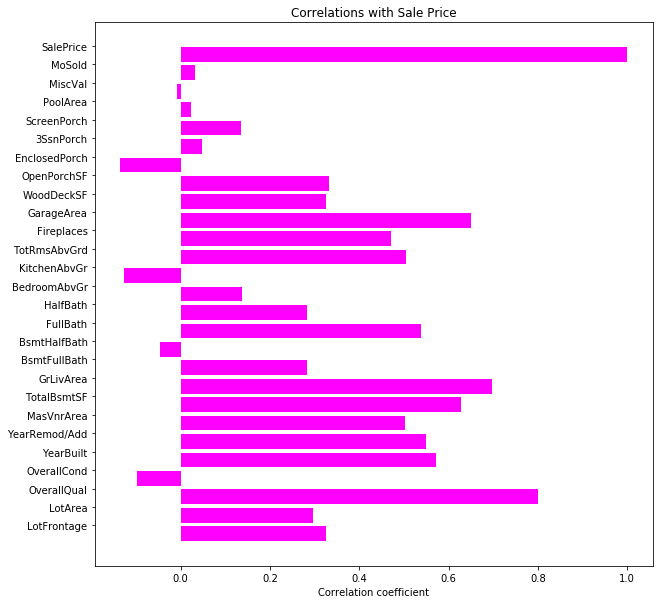

In [32]:
# num_feat=house.columns[house.dtypes!=object]
# num_feat=num_feat[1:-2] 
labels = []
values = []
for col in numeric_columns:
    labels.append(col)
    values.append(np.corrcoef(train[col].values, train.SalePrice.values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(10,10))
rects = ax.barh(ind, np.array(values), color='magenta')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlations with Sale Price")

## Scatterplots for Numeric Columns

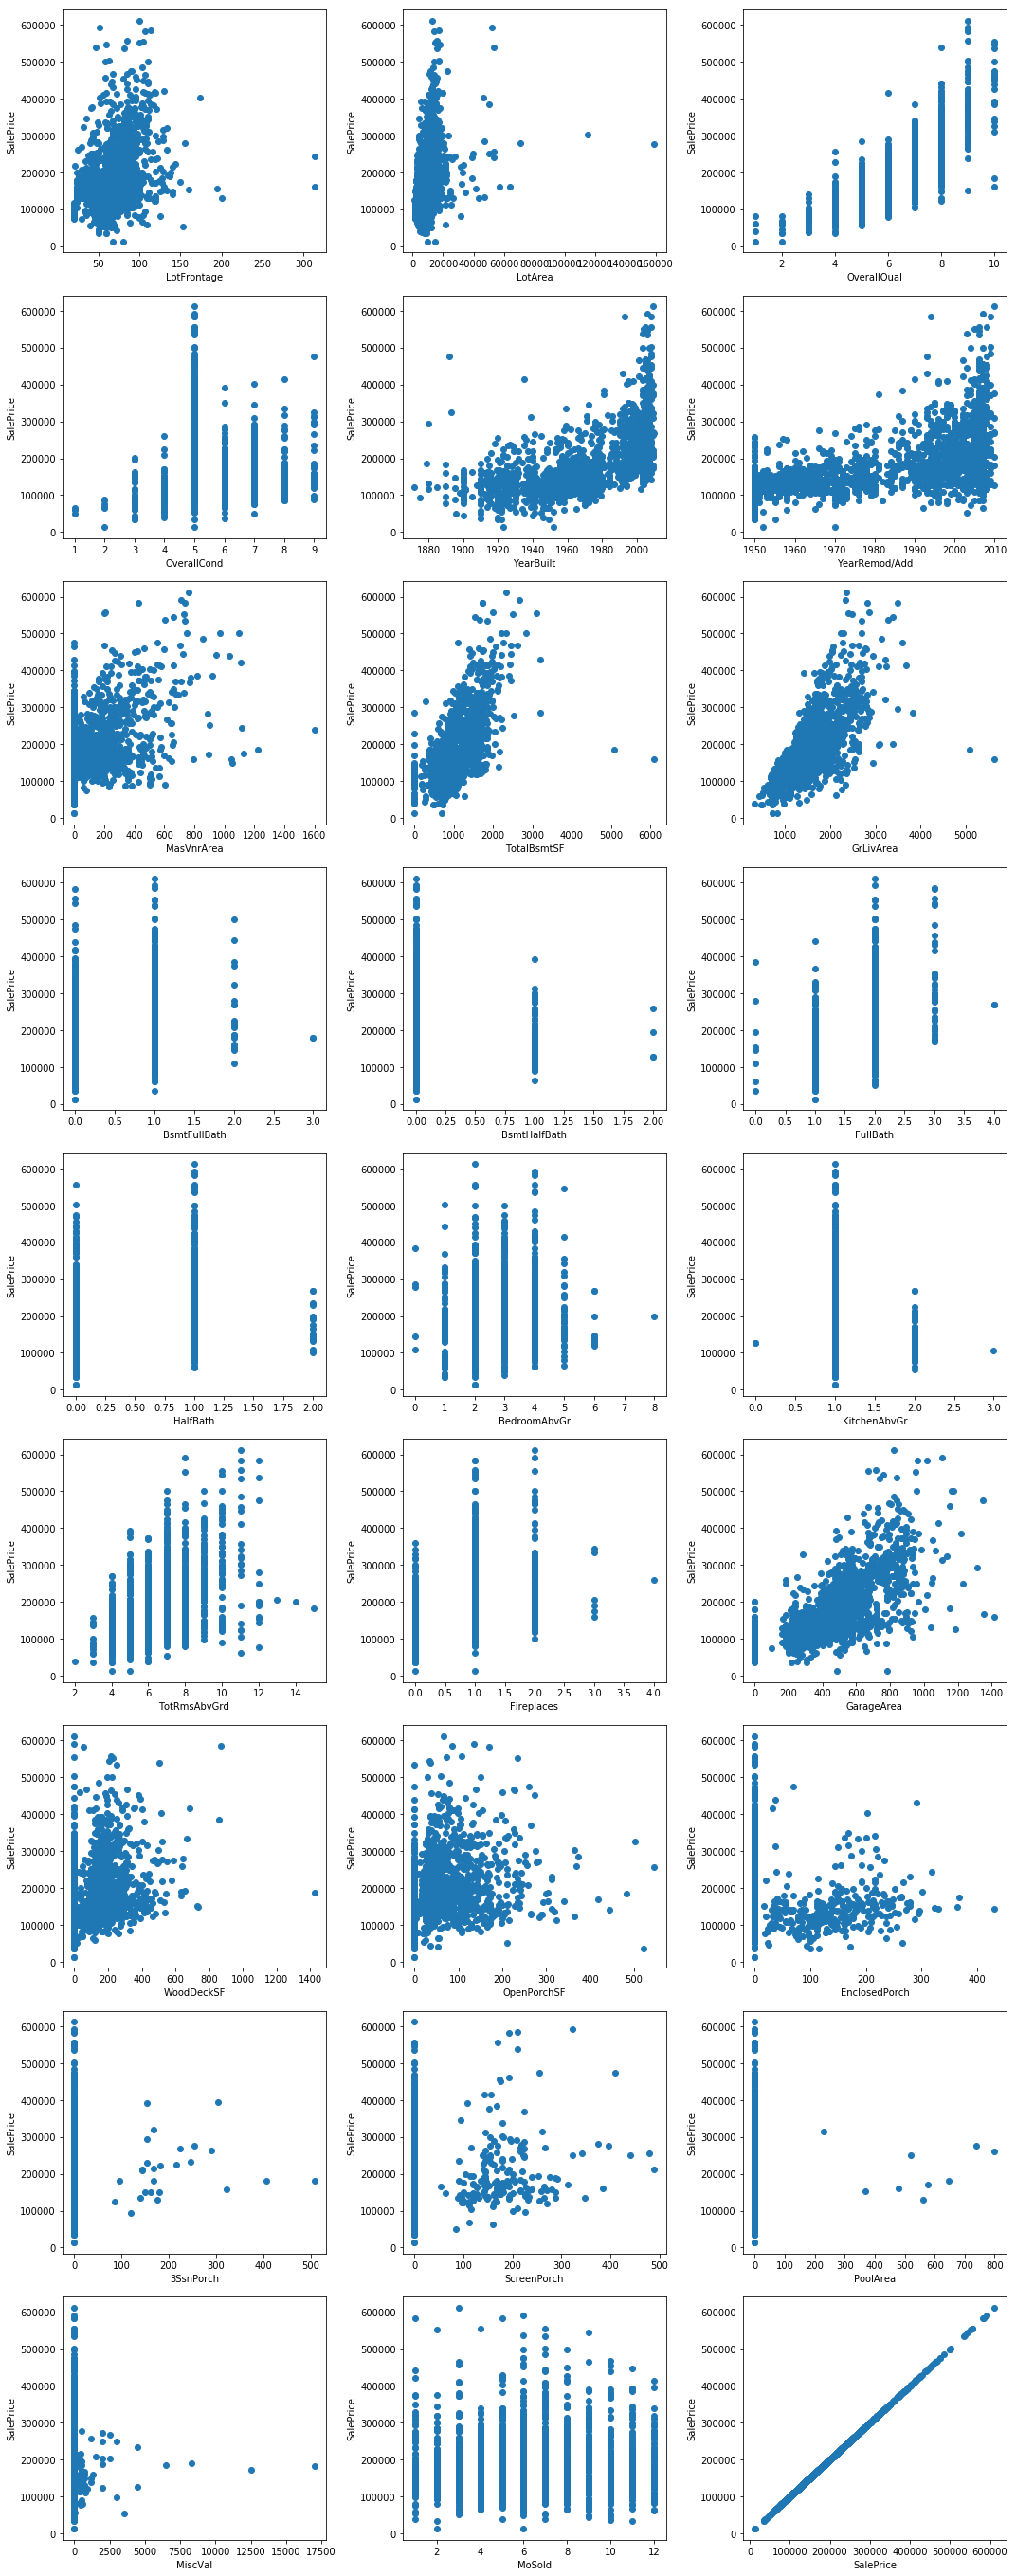

In [33]:
fig = plt.figure(figsize=(15,50))
for i, col in enumerate(numeric_columns):
    fig.add_subplot(12,3,1+i)
    plt.scatter(train[col], train['SalePrice'])
    plt.xlabel(col)
    plt.ylabel('SalePrice')
fig.tight_layout()
fig.show()

fig.savefig('numeric_scatter.png');

## Outliers

Removing outliers.  

In [34]:
train = train[train['LotFrontage'] < 300]

In [35]:
train = train[train['LotArea'] < 100000]

In [36]:
train = train[train['TotalBsmtSF'] < 5000]

In [37]:
train = train[train['GrLivArea'] < 5000]

In [38]:
train = train[train['WoodDeckSF'] < 1400]

## Clean Test Data

In [39]:
test = pd.read_csv('./data/test.csv')

## Remove Spaces in Column Titles

In [40]:
test.columns = test.columns.str.replace(' ', '')

## Drop Columns

In [41]:
test.drop(['Id', 'PID'], axis=1, inplace=True)

## Change Type for Columns

In [42]:
test['MSSubClass'] = test['MSSubClass'].astype(object)
test['YrSold'] = test['YrSold'].astype(object)

## Null Values

In [43]:
categorical_null_cols = ['MiscFeature', 'Alley', 'Fence',
 'FireplaceQu','GarageQual', 'GarageCond',
 'GarageFinish','GarageType', 'BsmtExposure',
 'BsmtFinType2', 'BsmtCond', 'BsmtQual',
 'BsmtFinType1', 'MasVnrType']

In [44]:
for col in test.columns:
    if col in categorical_null_cols:
        test[col].fillna(value = 'None', inplace=True)

In [45]:
numeric_null_cols = ['BsmtHalfBath',
 'BsmtFullBath','GarageCars']

In [46]:
numeric_median_cols = ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 
           'BsmtUnfSF', 'GarageArea', 'TotalBsmtSF']

In [47]:
for col in test.columns:
    if col in numeric_null_cols:
        test[col].fillna(value = 0, inplace=True)

In [48]:
for col in test.columns:
    if col in numeric_median_cols:
        test[col].fillna(value = test[col].median(), inplace=True)

In [49]:
counter = 0
for x in test[test['GarageYrBlt'].notnull()][['GarageYrBlt','YearBuilt']].values:
    if x[0] == x[1]:
        counter += 1
print(counter)

663


In [50]:
test.loc[test['GarageYrBlt'].isnull(), 'GarageYrBlt'] = test[test['GarageYrBlt'].isnull()]['YearBuilt']

## Feature Engineering

In [51]:
test.loc[test['YearBuilt'] != test['YearRemod/Add'], 'Remodeled'] = 'Remodeled'

In [52]:
test.loc[test['YearBuilt'] == test['YearRemod/Add'], 'Remodeled'] = 'Not Remodeled'

In [53]:
columns_to_remove = []

columns_to_remove.append('GarageCars')
columns_to_remove.append('GarageYrBlt')

columns_to_remove.append('BsmtFinSF1')
columns_to_remove.append('BsmtFinSF2')
columns_to_remove.append('BsmtUnfSF')

columns_to_remove.append('1stFlrSF')
columns_to_remove.append('2ndFlrSF')
columns_to_remove.append('LowQualFinSF')



test.drop(columns_to_remove, axis=1, inplace=True)

## Outliers

In [54]:
test = test[test['LotFrontage'] < 300]

In [55]:
test = test[test['LotArea'] < 100000]

In [56]:
test = test[test['TotalBsmtSF'] < 5000]

In [57]:
test = test[test['GrLivArea'] < 5000]

In [58]:
test = test[test['WoodDeckSF'] < 1400]

## Create Dummies

In [59]:
train = pd.get_dummies(train)

In [60]:
train.shape

(2045, 314)

In [61]:
test = pd.get_dummies(test)

In [64]:
test.shape

(877, 296)

## Make Sure Train and Test Data Have Same Number/Order of Columns 

In [65]:
# test[train.columns]
# train[test.columns]

In [66]:
test['RoofMatl_Metal'] = 0

In [67]:
test['RoofMatl_Roll'] = 0

In [68]:
test['Exterior1st_PreCast'] = 0

In [69]:
test['Exterior2nd_Other'] = 0

In [70]:
test['Exterior2nd_PreCast'] = 0

In [71]:
test['MasVnrType_CBlock'] = 0

In [72]:
test['Heating_Floor'] = 0

In [73]:
test['KitchenQual_Po'] = 0

In [74]:
test['SaleType_VWD'] = 0

In [75]:
train['SalePrice'] = 0

In [76]:
train['MSSubClass_150'] = 0

In [77]:
train['MSZoning_A (agr)'] = 0

In [78]:
train['Utilities_NoSeWa'] = 0

In [79]:
train['Neighborhood_GrnHill'] = 0

In [80]:
train['Neighborhood_Landmrk'] = 0

In [81]:
train['Condition2_Artery'] = 0

In [82]:
train['Condition2_RRAe'] = 0

In [83]:
train['Condition2_RRAn'] = 0

In [84]:
train['Condition2_RRNn'] = 0

In [85]:
train['RoofMatl_Membran'] = 0

In [86]:
train['Exterior1st_CBlock'] = 0

In [87]:
train['Exterior1st_ImStucc'] = 0

In [88]:
train['Exterior1st_Stone'] = 0

In [89]:
train['Exterior2nd_Stone'] = 0

In [90]:
train['BsmtCond_Ex'] = 0

In [91]:
train['BsmtCond_Po'] = 0

In [92]:
train['Heating_OthW'] = 0

In [93]:
train['Heating_Wall'] = 0

In [94]:
train['HeatingQC_Po'] = 0

In [95]:
train['Electrical_Mix'] = 0

In [96]:
train['Functional_Sal'] = 0

In [97]:
train['Functional_Sev'] = 0

In [98]:
train['GarageQual_Ex'] = 0

In [99]:
train['PoolQC_Fa'] = 0

In [100]:
train['PoolQC_Gd'] = 0

In [101]:
train['MiscFeature_TenC'] = 0

Make sure there is a difference of 36 columns combined between the two datasets

In [102]:
len(list(set(train.columns).difference(test.columns)))

27

In [103]:
len(list(set(test.columns).difference(train.columns)))

9

## Set Up X and Y

In [143]:
y = train['SalePrice']
X = train[[col for col in train.columns if col != target]]

In [142]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: SalePrice, dtype: int64

## Create training and validation set

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)

## Modeling

## Scale the Data

In [145]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

## Instantiate the model

In [146]:
lr = LinearRegression()

## Fit the model

In [147]:
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

## Raw/Scaled Score

In [152]:
results = list()

In [153]:
raw_train_score = lr.score(X_train, y_train)
raw_test_score = lr.score(X_test, y_test)

results.append({'name':'raw',
                'model': 'no model',
                'dataset' : 'train',
                'preprocessing': 'raw',
                'score': raw_train_score})

results.append({'name':'raw',
                'model':'no model',
                'dataset' : 'test',
                'preprocessing': 'raw',
                'score': raw_test_score})

## Scaled Results Dictionary

In [164]:
scaled_train_score = lr.score(X_train_sc, y_train)
scaled_test_score = lr.score(X_test_sc, y_test)

results.append({'name':'scaled',
                'model': 'no model',
                'dataset' : 'train',
                'preprocessing': 'scaled',
                'score': scaled_train_score})

results.append({'name':'scaled',
                'model':'no model',
                'dataset' : 'test',
                'preprocessing': 'scaled',
                'score': scaled_test_score})

TypeError: Can only append a Series if ignore_index=True or if the Series has a name

## Regularization

In [156]:
ridge = Ridge()
lasso = Lasso()
enet = ElasticNet()

In [158]:
ridge_fit = ridge.fit(X_train_sc, y_train)
lasso_fit = lasso.fit(X_train_sc, y_train)
enet_fit = enet.fit(X_train_sc, y_train)

In [161]:
train_ridge_score = ridge.score(X_train_sc, y_train)
test_ridge_score = ridge.score(X_test_sc, y_test)
train_lasso_score = lasso.score(X_train_sc, y_train)
test_lasso_score = lasso.score(X_test_sc, y_test)
train_enet_score = enet.score(X_train_sc, y_train)
test_enet_score = enet.score(X_test_sc, y_test)

In [163]:
results.append({'name': 'ridge',
                'model': ridge_fit,
                'dataset': 'train',
                'preprocessing': 'scaled',
                'score': train_ridge_score})

results.append({'name': 'ridge',
                'model': ridge_fit,
                'dataset': 'test',
                'preprocessing': 'scaled',
                'score': test_ridge_score})

results.append({'name': 'lasso',
                'model': lasso_fit,
                'dataset': 'train',
                'preprocessing': 'scaled',
                'score': train_lasso_score})

results.append({'name': 'lasso',
                'model': lasso_fit,
                'dataset': 'test',
                'preprocessing': 'scaled',
                'score': test_lasso_score})

results.append({'name': 'elastic net',
                'model': scaled_enet,
                'dataset': 'train',
                'preprocessing': 'scaled',
                'score': train_enet_score})

results.append({'name': 'elastic net',
                'model': scaled_enet,
                'dataset': 'test',
                'preprocessing': 'scaled',
                'score': test_enet_score})

TypeError: Can only append a Series if ignore_index=True or if the Series has a name

In [113]:
print(lr.intercept_)

0.0


In [114]:
print(lr.coef_)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

## Interpreting Model Coefficients

In [115]:
list(zip(X.columns, lr.coef_))

[('LotFrontage', 0.0),
 ('LotArea', 0.0),
 ('OverallQual', 0.0),
 ('OverallCond', 0.0),
 ('YearBuilt', 0.0),
 ('YearRemod/Add', 0.0),
 ('MasVnrArea', 0.0),
 ('TotalBsmtSF', 0.0),
 ('GrLivArea', 0.0),
 ('BsmtFullBath', 0.0),
 ('BsmtHalfBath', 0.0),
 ('FullBath', 0.0),
 ('HalfBath', 0.0),
 ('BedroomAbvGr', 0.0),
 ('KitchenAbvGr', 0.0),
 ('TotRmsAbvGrd', 0.0),
 ('Fireplaces', 0.0),
 ('GarageArea', 0.0),
 ('WoodDeckSF', 0.0),
 ('OpenPorchSF', 0.0),
 ('EnclosedPorch', 0.0),
 ('3SsnPorch', 0.0),
 ('ScreenPorch', 0.0),
 ('PoolArea', 0.0),
 ('MiscVal', 0.0),
 ('MoSold', 0.0),
 ('MSSubClass_20', 0.0),
 ('MSSubClass_30', 0.0),
 ('MSSubClass_40', 0.0),
 ('MSSubClass_45', 0.0),
 ('MSSubClass_50', 0.0),
 ('MSSubClass_60', 0.0),
 ('MSSubClass_70', 0.0),
 ('MSSubClass_75', 0.0),
 ('MSSubClass_80', 0.0),
 ('MSSubClass_85', 0.0),
 ('MSSubClass_90', 0.0),
 ('MSSubClass_120', 0.0),
 ('MSSubClass_150', 0.0),
 ('MSSubClass_160', 0.0),
 ('MSSubClass_180', 0.0),
 ('MSSubClass_190', 0.0),
 ('MSZoning_A (agr)'